In [15]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy.io as sio

import keras
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Dropout, Conv1D, Flatten, MaxPooling1D, LeakyReLU, ELU
from keras import regularizers , optimizers
from keras.constraints import maxnorm

from keras.utils import to_categorical

In [5]:
###############  1 - LOADING PORTION OF TRAINING AND DEV SET ############### 
## 1.1 - loading training set
train = h5py.File('/floyd/input/echogrampreprocessed/EchogramPreprocessed.mat','r')
label_train = np.array(train['label'])
X_train = np.array(train['EchogramWithBottom'])

In [6]:
## 1.2 - Resizing the training set, 
# in fact there is too many pings ~2.3 million it won't fit into memory
np.random.seed(7)
m,_ = X_train.shape
index = np.random.choice(m,500000,replace=False)
label_train = label_train[index,:]
X_train = X_train[index,:]

In [7]:
## 1.3 - Preprocessing step
# Replacing Nan with -200
X_train = np.add(np.nan_to_num(X_train),np.isnan(X_train) * -200)

In [4]:
## 1.4 - loading development set
dev = sio.loadmat('/floyd/input/devset/EchogramDev.mat')
X = np.array(dev['Echogram'])
label = np.array(dev['label'])

# Replacing Nan with -200
X = np.add(np.nan_to_num(X), np.isnan(X) * -200)

# We select 50,000 examples from the development set to inject it into the
# training set so that the model learn from a cross domain data set
X1 = X[:50000,:]
label1 = label[:50000,:]

# In the same time we reform another development set 
# Hence the portion X1, label1 will go into the new set cross domain training set X_cd_train
# But we still need a development set to evaluate our model, that's the purpose of X_dev, label_dev
X_dev = X[50000:,:]
label_dev = label[50000:,:]
m_dev,_ = X_dev.shape
belong_dev = np.zeros(m_dev)

In [8]:
############### 2 - MERGE AND RESHAPE THE TWO DATASETS  ############### 
#### 2.1 - Create a belong label
# We need to know wether a ping belong to the training set or
# to the development set, since we don't have the same number of pings
# 500K for the training set and 50K for the development set
# we want to be able to distinguish each ping so that the pings from the 
# development set are more penalized.


m_train,_ = X_train.shape
m1,_ = X1.shape

# The a ping has belong = 1 if it was in the training set before
# and 0 if not
belong_cd_train = np.zeros(m_train+m1) 
belong_cd_train[:m_train] = 1

#### 2.2 - Now we merge the all files
X_cd_train = np.concatenate((X_train,X1),axis=0)
label_cd_train = np.concatenate((label_train,label1),axis=0)

In [9]:
## 2.3 - Reshaping the data to feed the convolutional neural network
# Reshaping the training data
m_cd_train,n = X_cd_train.shape
X_cd_train = X_cd_train.reshape(m_cd_train,n,1)

# Reshaping the dev set
X_dev = X_dev.reshape(m_dev,n,1)

# Preparing the labels in a categorical form: 
# each class is a vector either [1,0] or [0,1]
Y_cd_train = to_categorical(label_cd_train)
Y_cd_train = Y_cd_train[:,1:]
Y_dev =  to_categorical(label_dev)
Y_dev =  Y_dev[:,1:]


In [10]:
############### 3 - DEFINING OUR MODEL ############### 
## 3.1 - Defining the Cross Domain Learning Function
## You can check how the function look in the presentation
def CDloss(belong,beta):
    def loss(y_true, y_pred):
         return K.mean(belong*K.binary_crossentropy(y_true, y_pred) + beta*(1-belong)* K.binary_crossentropy(y_true, y_pred))
    return loss

In [11]:
## 3.2 Defining our model

def CrossDomainNN(kernel_1, kernel_2, kernel_3, no_unit1, no_unit2, no_unit3, dropout1, dropout2):
    ## Input Layer
    inputs = Input(shape=(2550,1))
    belong = Input(shape=(1,))
    
    ## 1st Conv Layer
    x = Conv1D(filters=1, kernel_size=kernel_1, kernel_initializer="normal", strides=2, activation='selu')(inputs)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling1D(pool_size=kernel_1, strides=1, padding='valid')(x)
    
    ## 2nd Conv Layer
    x = Conv1D(filters=1, kernel_size=kernel_2, kernel_initializer="normal", strides=1, activation='selu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling1D(pool_size=kernel_2, strides=1, padding='valid')(x) 
    
    ## 3rd Conv Layer
    x = Conv1D(filters=1, kernel_size=kernel_3, kernel_initializer="normal", strides=1, activation='selu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling1D(pool_size=kernel_3, strides=1, padding='valid')(x) 
    x = Flatten()(x)
    
    ## Fully Connected Layers
    x = Dropout(dropout1)(x)
    x = Dense(no_unit1,kernel_initializer="normal", bias_initializer='zeros', activation='selu',kernel_constraint=maxnorm(3))(x)
    x = Dropout(dropout2)(x)
    x = Dense(no_unit2,kernel_initializer="normal", bias_initializer='zeros', activation='selu',kernel_constraint=maxnorm(3))(x) 
    x = Dense(no_unit3,kernel_initializer="normal", bias_initializer='zeros', activation='selu',kernel_constraint=maxnorm(3))(x)
    predictions = Dense(2, kernel_initializer="normal", bias_initializer='zeros', activation='sigmoid')(x)
    
    ## Getting the model
    model = Model(inputs=[inputs,belong], outputs = predictions)
    model.compile(optimizer='adam', loss=CDloss(belong,beta = 10), metrics=['accuracy'])
    return model

In [13]:
cdnn = CrossDomainNN(56, 54, 13,303, 202,  81, 0.5, 0.6)
cdnn.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2550, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1248, 1)           57        
_________________________________________________________________
batch_normalization_1 (Batch (None, 1248, 1)           4         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1193, 1)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1140, 1)           55        
_________________________________________________________________
batch_normalization_2 (Batch (None, 1140, 1)           4         
___________________________________________________________

In [16]:
%%time
filepath="CDNN_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = cdnn.fit([X_cd_train,belong_cd_train], Y_cd_train, validation_data = ([X_dev,belong_dev],Y_dev), epochs = 50, callbacks=callbacks_list, batch_size = 8192, shuffle = True)

Train on 550000 samples, validate on 50000 samples
Epoch 1/50
550000/550000 [==============================] - 73s 133us/step - loss: 0.3366 - acc: 0.8755 - val_loss: 0.8695 - val_acc: 0.9858

Epoch 00001: val_acc improved from -inf to 0.98582, saving model to CDNN_weights.hdf5
Epoch 2/50
550000/550000 [==============================] - 32s 58us/step - loss: 0.2762 - acc: 0.8864 - val_loss: 1.0424 - val_acc: 0.9858

Epoch 00002: val_acc did not improve from 0.98582
Epoch 3/50
550000/550000 [==============================] - 32s 58us/step - loss: 0.2733 - acc: 0.8888 - val_loss: 5.5233 - val_acc: 0.9246

Epoch 00003: val_acc did not improve from 0.98582
Epoch 4/50
550000/550000 [==============================] - 32s 58us/step - loss: 0.2687 - acc: 0.8905 - val_loss: 11.0440 - val_acc: 0.2450

Epoch 00004: val_acc did not improve from 0.98582
Epoch 5/50
550000/550000 [==============================] - 32s 58us/step - loss: 0.2561 - acc: 0.8929 - val_loss: 6.0494 - val_acc: 0.8244

Epoch 

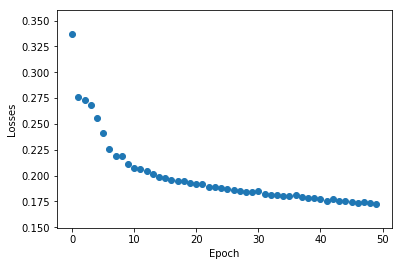

In [17]:
############### 4 - RESULTS ############### 
## Diagnosing the learning phase
losses = history.history["loss"]
epoch = history.epoch
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.scatter(epoch, losses)
plt.show()

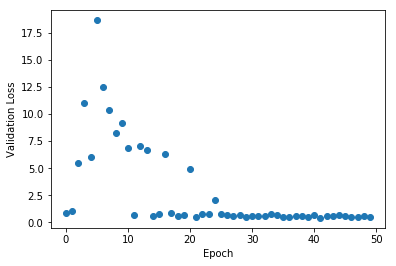

In [18]:
## Diagnosing the learning phase
losses = history.history["val_loss"]
epoch = history.epoch
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.scatter(epoch, losses)
plt.show()

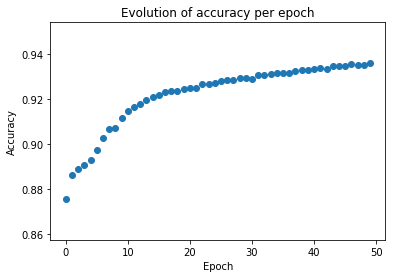

In [19]:
# Plot the accuracies
acc = history.history["acc"]
epoch = history.epoch
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.scatter(epoch, acc)
plt.title('Evolution of accuracy per epoch')
plt.show()

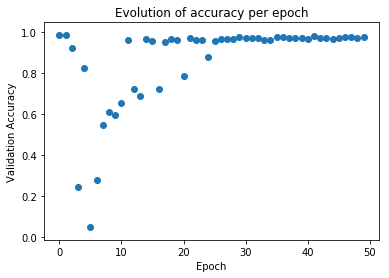

In [20]:
# Plot the accuracies
acc = history.history["val_acc"]
epoch = history.epoch
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.scatter(epoch, acc)
plt.title('Evolution of accuracy per epoch')
plt.show()

In [21]:
training_error = cdnn.evaluate([X_cd_train,belong_cd_train],Y_cd_train, batch_size = 8192)
validation_error = cdnn.evaluate([X_dev,belong_dev],Y_dev, batch_size = 8192)
print("training error:", training_error)
print("validation error:", validation_error)

50000/50000 [==============================] - 2s 37us/step
training error: [0.17941622887437994, 0.9364490909229626]
validation error: [0.4564550179862976, 0.9787400004196167]


In [22]:
cdnn.save('CDNN_final.h5')
training = history.history
sio.savemat('CDNN_history.mat', training)